In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
import optuna
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from data_downloader import DataDownloader, ClimateDataCleaner, EconomicDataCleaner
from vr_model import ClimateVR
from sdice_model import SimplifiedDICE, ScenarioDICE
from portfolio import PortfolioOptimizer

In [2]:
# Instancia para limpiar y procesar los datos
climate_data = ClimateDataCleaner('Data/Temperature.csv', 'Data/Drought_Severity.csv', 'Data/CO2_Emissions.xlsx').clean_and_prepare_data()
economic_data = EconomicDataCleaner('Data/GDP.csv', 'Data/TB3MS.csv', 'Data/CPI.csv').clean_and_prepare_data()

# Descarga los datos financieros
downloader = DataDownloader()
assets = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA', 'NEE', 'FSLR', 'VWDRY', 'BEP'] 
benchmark = '^GSPC'  
start_date = '2014-11-01'
end_date = '2024-05-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets, 
                                                          benchmark=benchmark)

# Fusiona los datos
data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
all_data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]

# Elimina la columna 'Date' de 'all_data'
all_data.drop('Date', axis=1, inplace=True)


[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Instanciar el modelo ClimateVR con los datos
vr_model = ClimateVR(all_data)

# Optimizar el número de retardos usando Optuna
optimal_maxlags, optimal_rmse = vr_model.optimize_maxlags(all_data=all_data, n_trials=100)
print(f'Número óptimo de retardos: {optimal_maxlags}')
print(f'RMSE óptimo: {optimal_rmse}')

# Ajustar el modelo VR con el número óptimo de retardos
vr_results = vr_model.fit(maxlags=optimal_maxlags)

# Realizar predicción futura con el número óptimo de retardos
predict = vr_model.predict(vr_results, lags=optimal_maxlags, end=len(all_data))

Número óptimo de retardos: 10
RMSE óptimo: 6663.531111588482


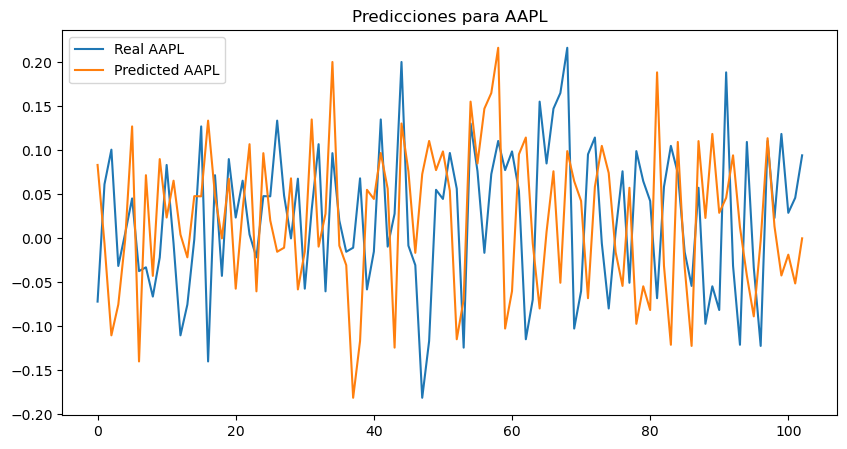

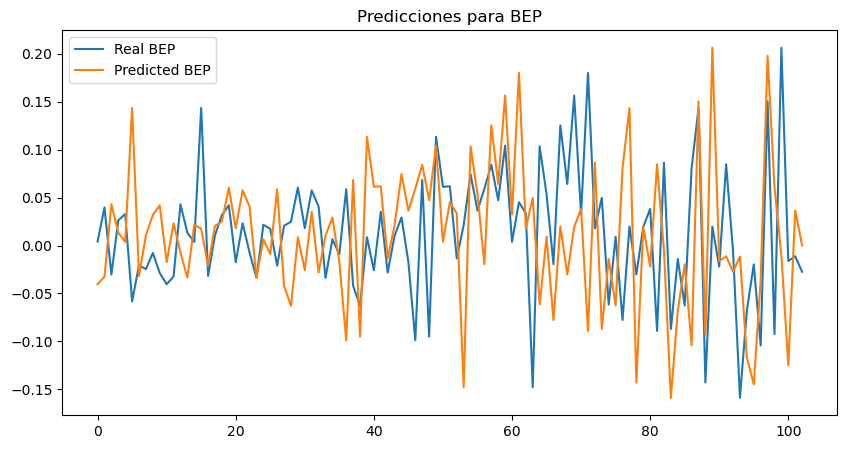

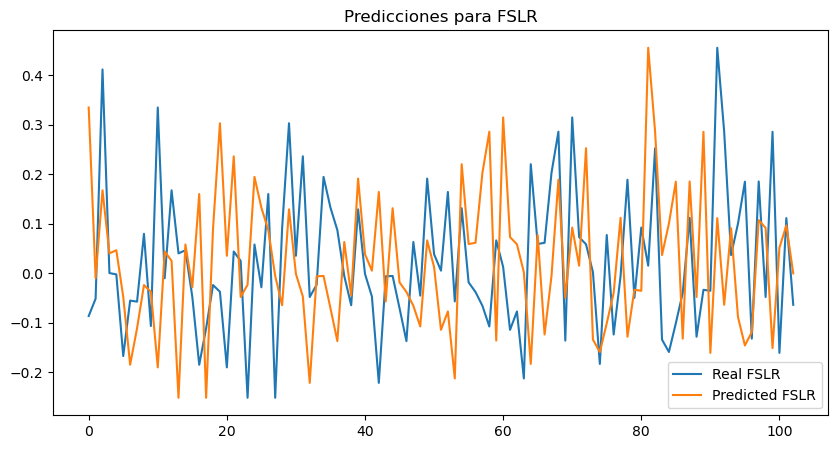

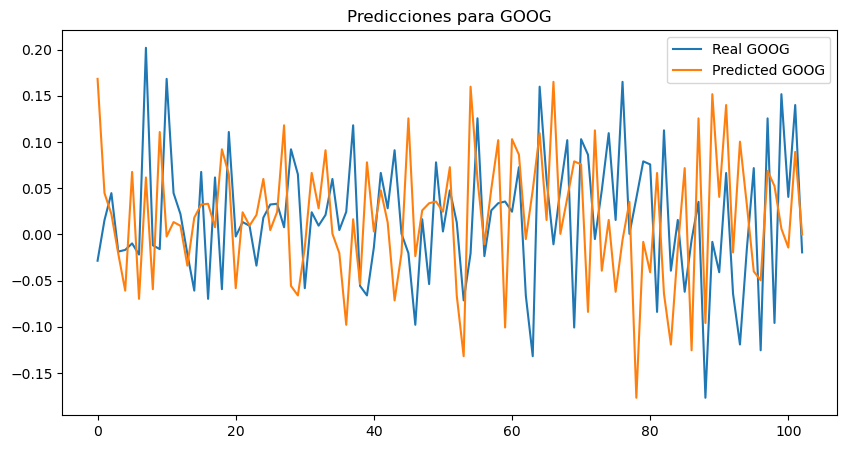

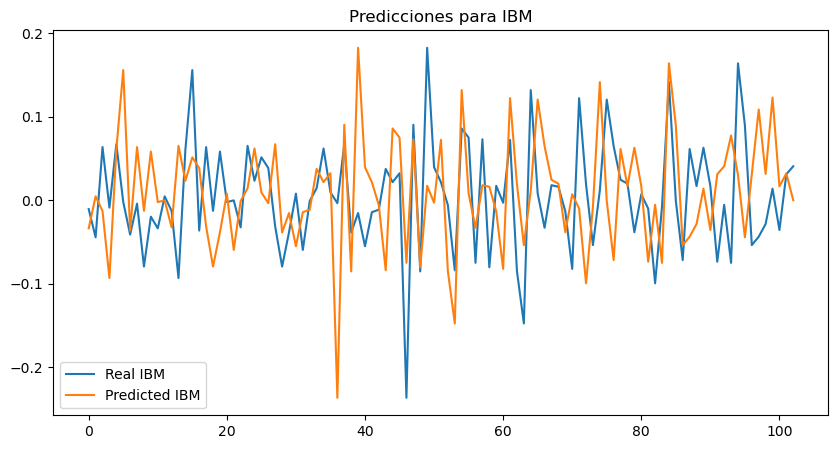

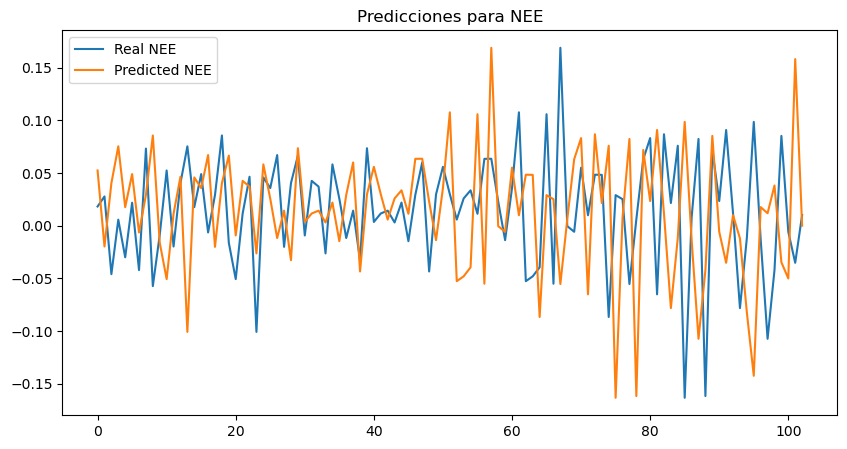

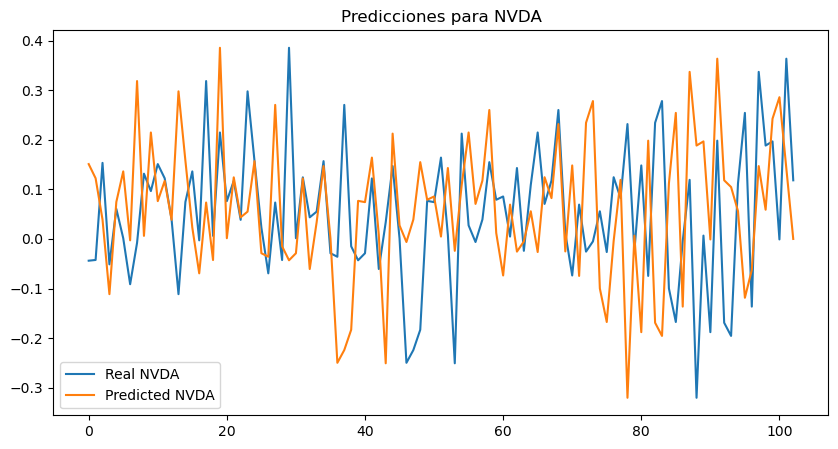

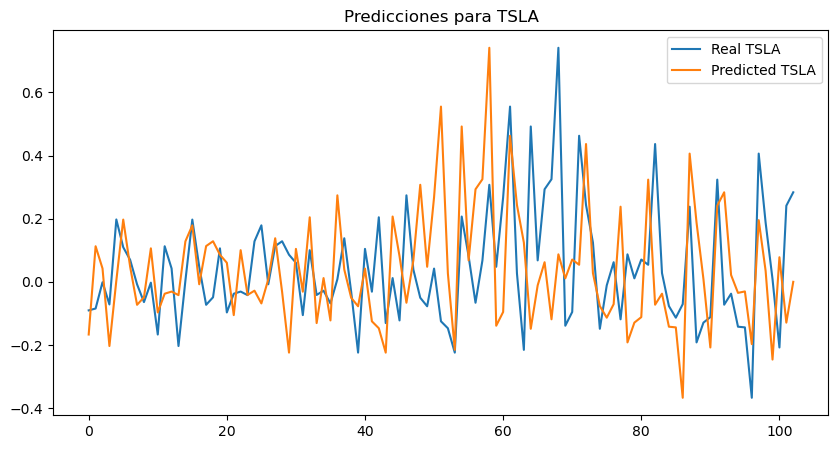

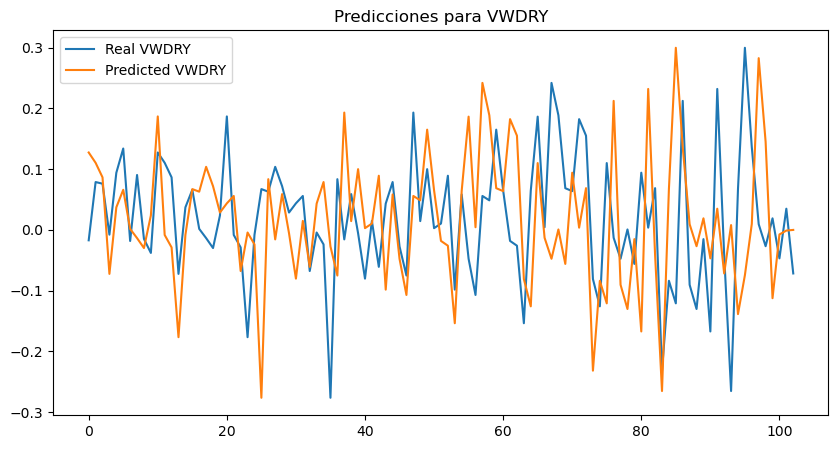

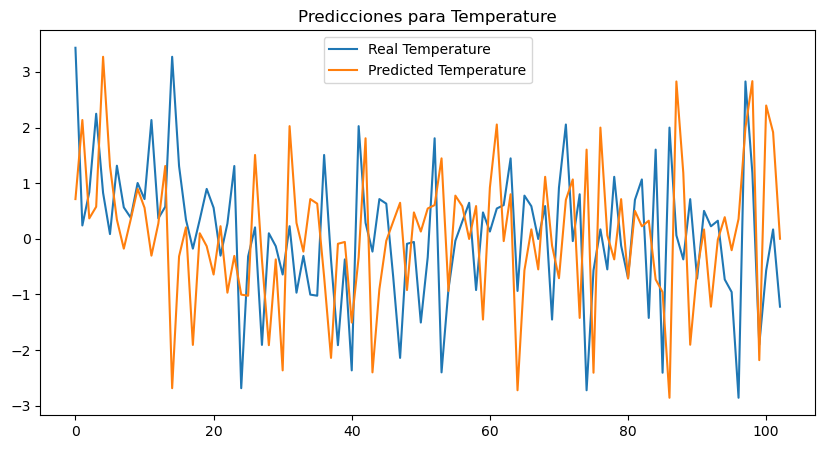

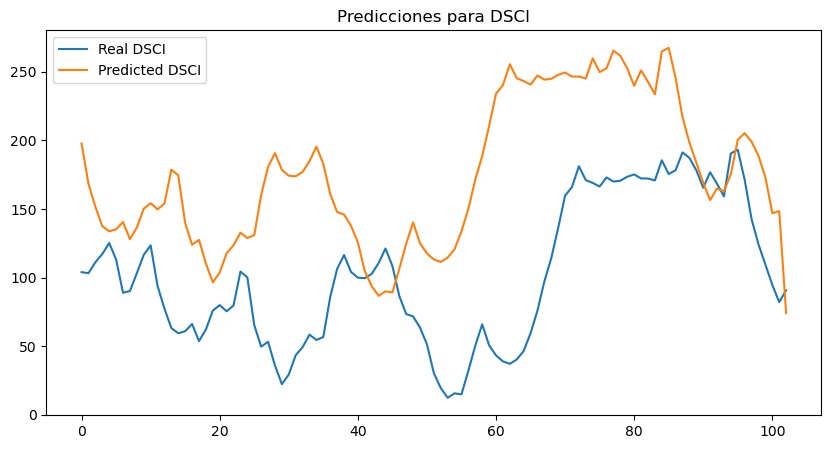

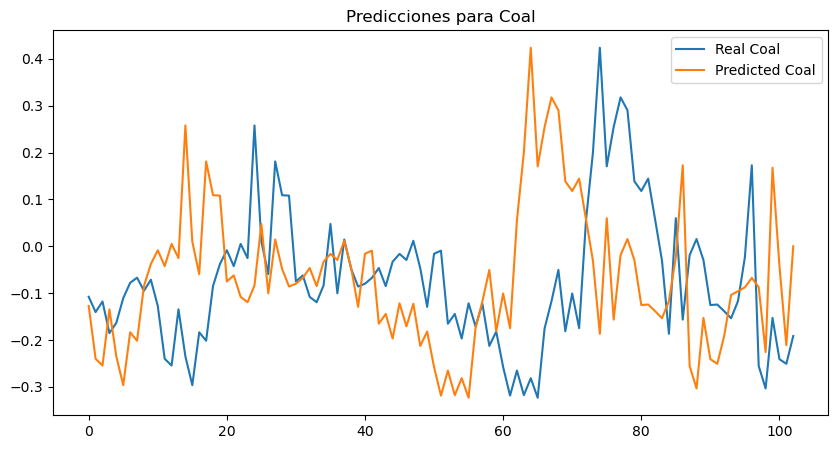

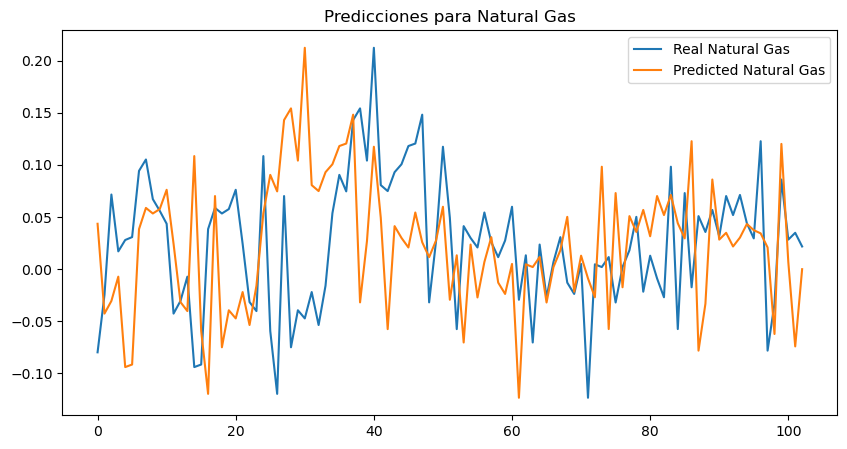

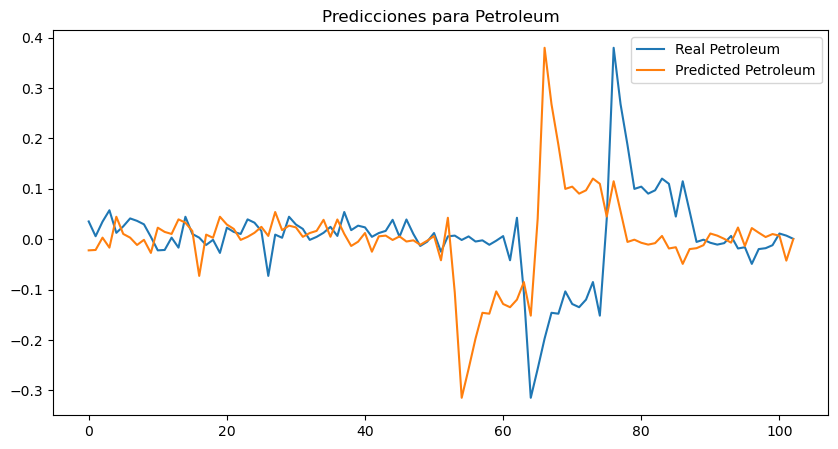

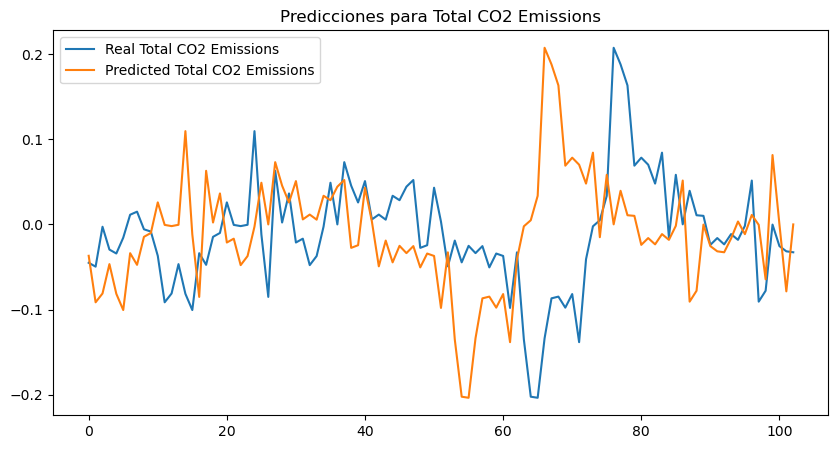

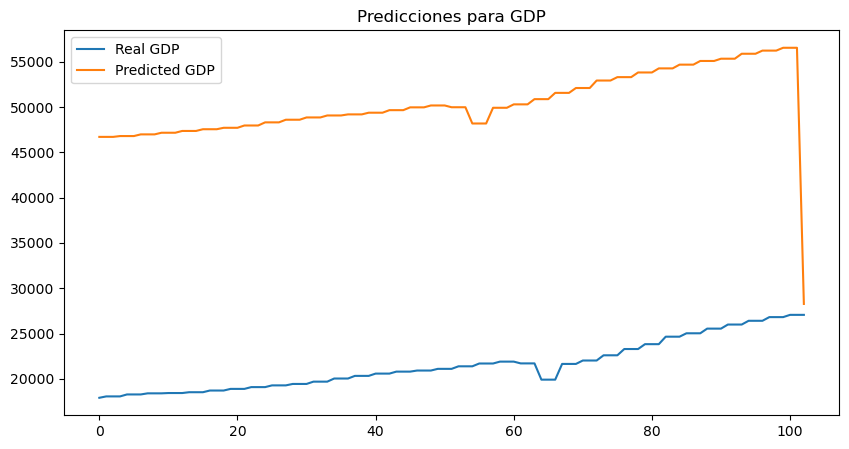

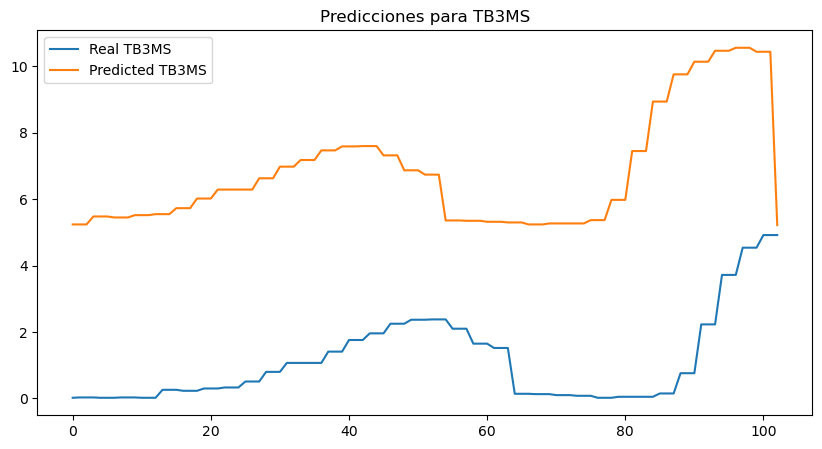

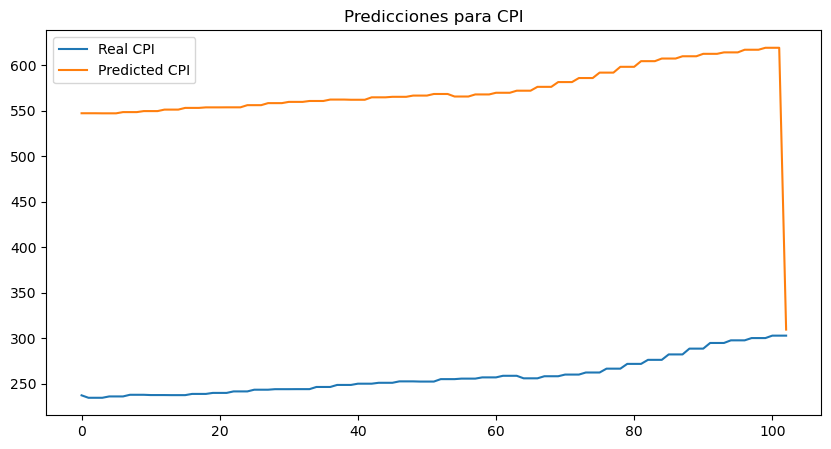

In [4]:
# Graficar las predicciones versus los datos originales
for i, column in enumerate(all_data.columns):
    plt.figure(figsize=(10, 5))
    plt.plot(all_data.index[:len(predict)], all_data.iloc[:len(predict), i], label=f"Real {column}")
    plt.plot(all_data.index[:len(predict)], predict[:, i], label=f"Predicted {column}")
    plt.title(f"Predicciones para {column}")
    plt.legend()
    plt.show()

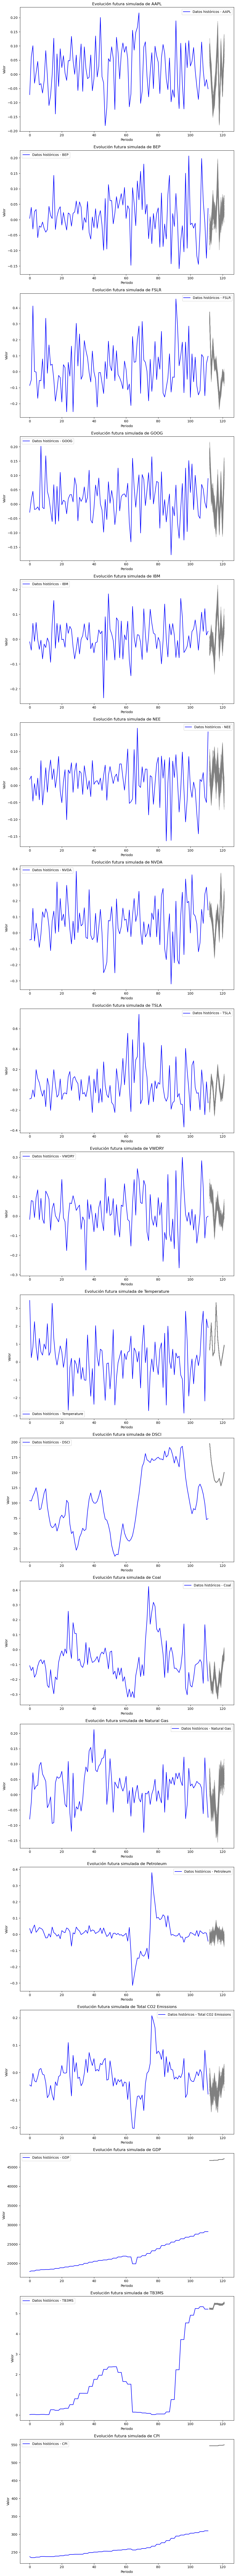

In [5]:
# Generar 100 escenarios para los próximos 10 periodos
scenarios = vr_model.simulate_scenarios(vr_results, lags=optimal_maxlags, n_scenarios=100, periods=10, noise_std=0.02)

# Graficar los resultados para cada variable no financiera, incluyendo datos históricos
n_variables = vr_model.neqs

fig, axs = plt.subplots(n_variables, 1, figsize=(10, 6 * n_variables))

for var_idx, var_name in enumerate(vr_model.endog.columns):
    
    # Graficar datos históricos
    axs[var_idx].plot(vr_model.endog.index, vr_model.endog.iloc[:, var_idx], label=f'Datos históricos - {var_name}', color='blue')
    
    # Graficar escenarios futuros
    for scenario in range(100):
        axs[var_idx].plot(range(len(vr_model.endog), len(vr_model.endog) + 10), scenarios[var_name][:, scenario], color='gray', alpha=0.5)
    
    axs[var_idx].set_title(f'Evolución futura simulada de {var_name}')
    axs[var_idx].set_xlabel('Periodo')
    axs[var_idx].set_ylabel('Valor')
    axs[var_idx].legend()

plt.tight_layout()
plt.show()

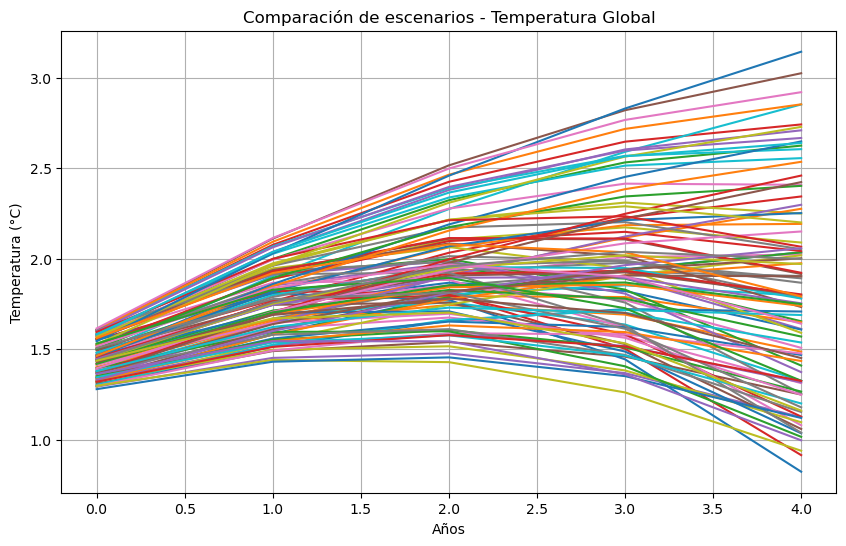

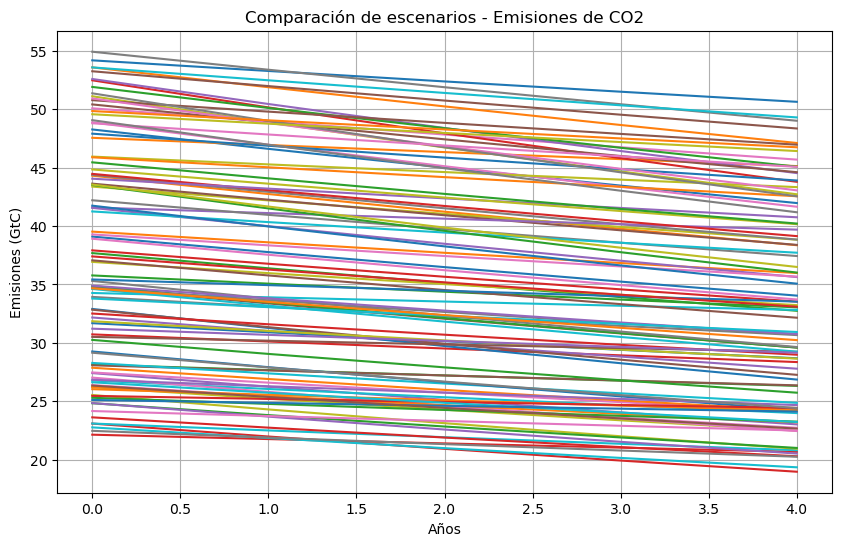

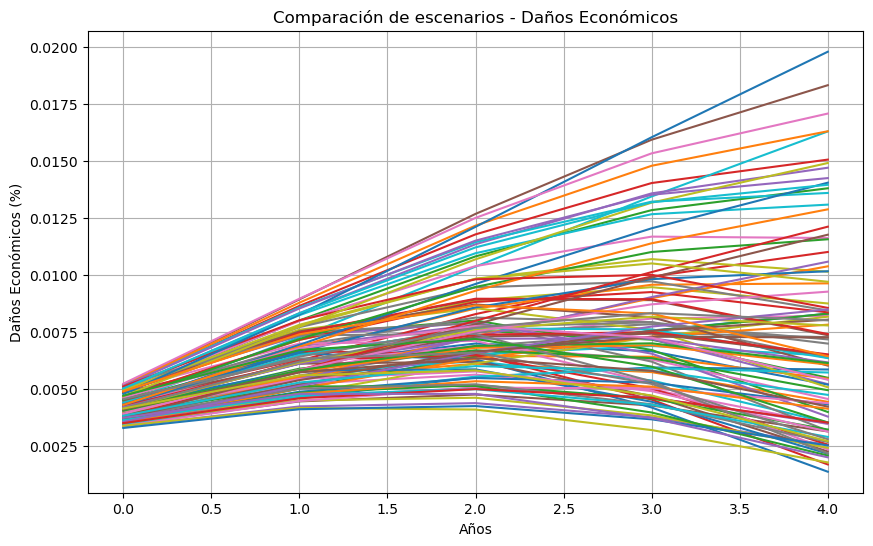

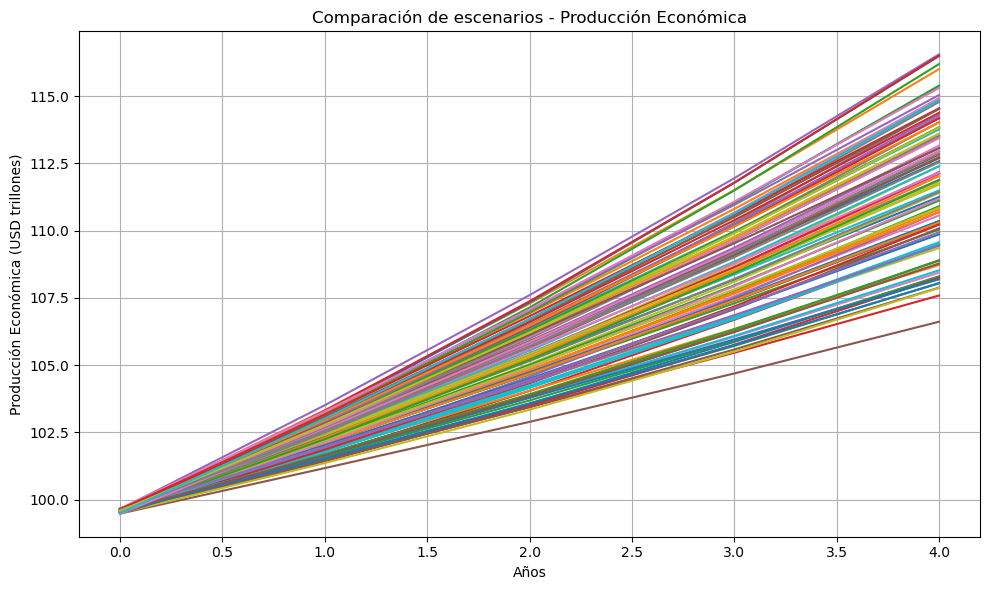

In [6]:
# Instanciar la clase ScenarioDICE
scenario_dice = ScenarioDICE()

# Generar 100 escenarios aleatorios
num_scenarios = 100
scenarios = scenario_dice.generate_random_scenarios(num_scenarios=num_scenarios)

years = 5
results = scenario_dice.simulate_multiple_scenarios(scenarios, years=years)
scenario_dice.plot_scenarios(results, years=years)

In [7]:
# Alinear asset_prices y benchmark_prices según el índice (fechas o índices comunes)
asset_prices, benchmark_prices = asset_prices.align(benchmark_prices, join='inner', axis=0)

# Inicializar el optimizador de portafolios
optimizer = PortfolioOptimizer(asset_prices=asset_prices, risk_free_rate=rf, benchmark_prices=benchmark_prices)
num_portfolios = 100000
strategies = ['sharpe', 'omega', 'sortino']  # Puedes elegir las estrategias que quieras

# Optimizar el portafolio utilizando múltiples estrategias
optimal_portfolios, ranked_portfolios_df = optimizer.optimize_with_multiple_strategies(num_portfolios=num_portfolios, strategies=strategies)

# Diccionario para almacenar los datos de portafolios
portfolios_data = {
    'strategy': [],
    'portfolio': [],
    'weights': [],
    'score': [],
    'jensen_alpha': [],
    'adjusted_return': []
}

# Iterar sobre las estrategias y los portafolios optimizados
for strategy, portfolios in optimal_portfolios.items():
    for i, (weights, score, adjusted_return) in enumerate(portfolios[:5]):  # Muestra los 5 mejores portafolios
        # Calcular Jensen's Alpha
        jensen_alpha = optimizer.calculate_jensen_alpha(weights)

        # Añadir los resultados al diccionario
        portfolios_data['strategy'].append(strategy)
        portfolios_data['portfolio'].append(f'Portafolio {i+1}')
        portfolios_data['weights'].append(weights)
        portfolios_data['score'].append(score)
        portfolios_data['jensen_alpha'].append(jensen_alpha)
        portfolios_data['adjusted_return'].append(adjusted_return)

# Convertir el diccionario en un DataFrame
portfolios_df = pd.DataFrame(portfolios_data)

# Imprimir todos los portafolios
print(portfolios_df)

   strategy     portfolio                                        weights  \
0    sharpe  Portafolio 1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]   
1    sharpe  Portafolio 2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]   
2    sharpe  Portafolio 3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]   
3    sharpe  Portafolio 4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]   
4    sharpe  Portafolio 5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]   
5     omega  Portafolio 1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]   
6     omega  Portafolio 2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]   
7     omega  Portafolio 3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]   
8     omega  Portafolio 4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]   
9     omega  Portafolio 5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]   
10  sortino  Portafolio 1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]   
11  sortino  Portafolio 2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]   
12  sortino 

In [8]:
# Buscar el portafolio con el mejor score
best_portfolio = portfolios_df.loc[portfolios_df['score'].idxmax()]

# Calcular el retorno promedio del mejor portafolio
average_return = np.mean(best_portfolio['adjusted_return'])

# Imprimir el mejor portafolio con su retorno promedio
print(f"\nRetorno promedio del mejor portafolio: {average_return:.4f}")
best_portfolio



Retorno promedio del mejor portafolio: 0.0576


strategy                                                     sortino
portfolio                                               Portafolio 1
weights                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
score                                                       0.072658
jensen_alpha                                                0.092638
adjusted_return    [-0.04387230846767509, -0.042394140358984034, ...
Name: 10, dtype: object